In [1]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

calibration_images = glob.glob('./camera_cal/calibration*.jpg')


In [2]:
# Arrays to store object points and image points

object_points = []
image_points = []

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Step through the list and search for chessboard corners
for fname in calibration_images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        object_points.append(objp)
        image_points.append(corners)

# calibrate the camera
img_shape = gray.shape[::-1]
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, img_shape, None, None)

# Source and destination points for perspective transform
src = np.float32(
    [[710,460], # top right
    [1180,720], # bottom right
    [100,720], # bottom left
    [570,460]]) # top left
dst = np.float32(
    [[900,0], # top right
    [900,720], # bottom right
    [300,720], # bottom left
    [300,0]]) # top left

# Prespective transform matrices
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
    

In [3]:
# Define gradient threshold functions

def abs_sobel_thresh(img, sobel_kernel=3, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude
            # is > thresh_min and < thresh_max
    sobel_binary = np.zeros_like(scaled_sobel)
    sobel_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    return sobel_binary


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    grad = np.sqrt(sobelx ** 2 + sobely ** 2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    grad_scaled = np.uint8(255*grad/np.max(grad))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(grad_scaled)
    binary_output[(grad_scaled >= mag_thresh[0]) & (grad_scaled <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(direction)
    binary_output[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output


def thresholds(undist_img):
    # Binary gradient thresholds
    gradx_bin = abs_sobel_thresh(undist_img, sobel_kernel=7, orient='x', thresh_min=70, thresh_max=255)
    grady_bin = abs_sobel_thresh(undist_img, sobel_kernel=7, orient='y', thresh_min=70, thresh_max=255)
    mag_bin = mag_thresh(undist_img, sobel_kernel=7, mag_thresh=(30, 255))
    #dir_bin = dir_threshold(undist_img, sobel_kernel=9, thresh=(0, 1.0))
    
    # Binary color channel thresholds
    hls = cv2.cvtColor(undist_img, cv2.COLOR_RGB2HLS)
    gray = cv2.cvtColor(undist_img, cv2.COLOR_RGB2GRAY)
    H = hls[:,:,0]
    S = hls[:,:,2]
    
    H_thresh = (15, 25)
    S_thresh = (100, 255)
    gray_thresh = (195, 255)
    
    H_bin = np.zeros_like(H)
    S_bin = np.zeros_like(S)
    gray_bin = np.zeros_like(gray)
    
    H_bin[(H > H_thresh[0]) & (H <= H_thresh[1])] = 1
    S_bin[(S > S_thresh[0]) & (S <= S_thresh[1])] = 1
    gray_bin[(gray > gray_thresh[0]) & (gray <= gray_thresh[1])] = 1
    
    # Combine the thresholds
    combined_img = np.zeros_like(gradx_bin)
    combined_img[((gradx_bin == 1) & (grady_bin == 1)) | ((H_bin == 1) & (S_bin == 1)) | ((gray_bin == 1) & (mag_bin == 1))] = 1
    #combined_img[((gray_bin == 1) & (mag_bin == 1))] = 1
    
    return combined_img



In [4]:
# Lane finding pipeline
def find_lanes(img, mtx=mtx, dist=dist, M=M, Minv=Minv):
    img_shape = (img.shape[1], img.shape[0])
    
    # Undistort the image
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Apply color and gradient thresholds
    combined_img = thresholds(undist_img)
    
    # Apply perspective transform
    binary_warped = cv2.warpPerspective(combined_img, M, img_shape, flags=cv2.INTER_LINEAR)
    
    #
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    output_img = (np.dstack((binary_warped, binary_warped, binary_warped))*255).astype(np.uint8)

    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = 9

    window_height = np.int(binary_warped.shape[0]/nwindows)

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    leftx_current = leftx_base
    rightx_current = rightx_base

    margin = 100

    minpix = 50

    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(output_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(output_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    output_img[lefty, leftx] = [255, 0, 0]
    output_img[righty, rightx] = [0, 0, 255]

    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / (2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / (2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, img_shape) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)

    return result, ploty, left_fitx, right_fitx

-4364.98064982 m 2824.82347931 m
-1255.62544002 m 175234.482983 m
1975.45128395 m 1976.19369865 m
-830.189576182 m 7489.39564713 m
1924.51816319 m 1307.04989284 m
1958.25607964 m 772.16128318 m
562.455652716 m 978.167373987 m
728.116400821 m 617.458473317 m


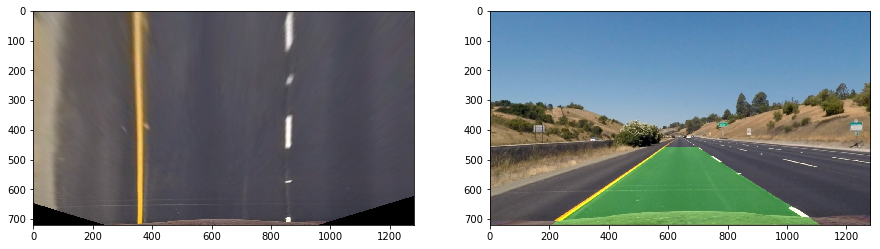

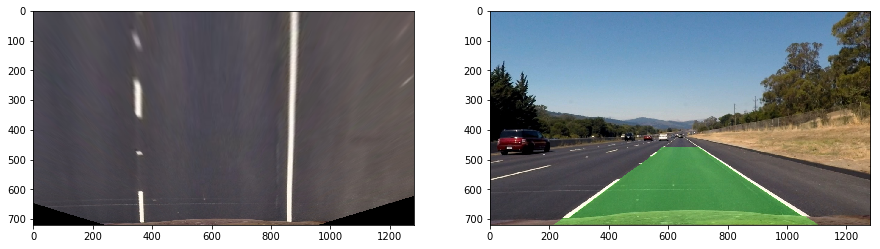

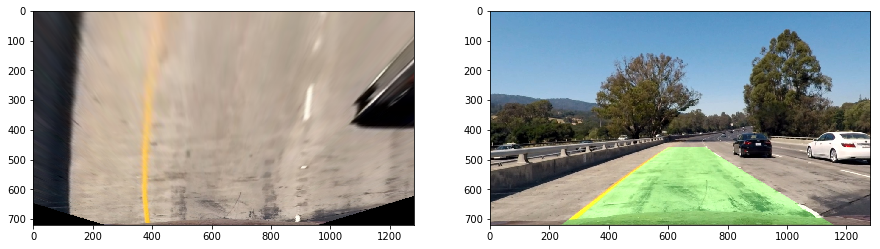

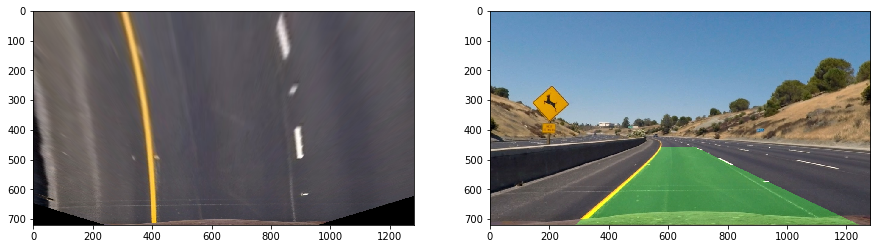

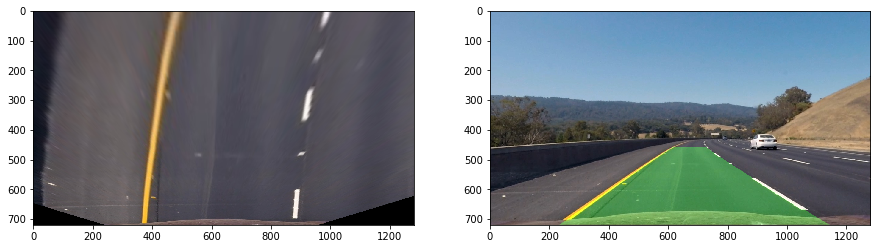

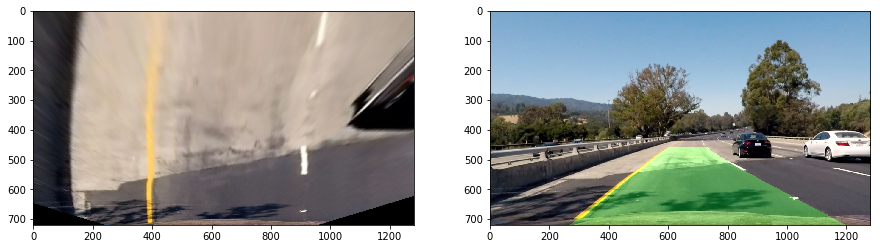

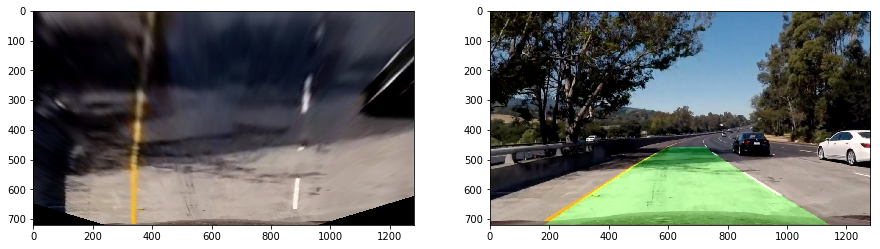

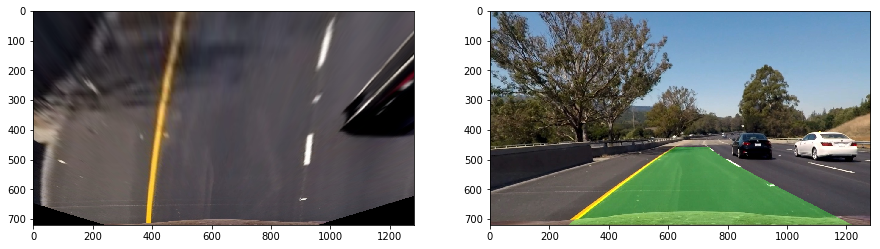

In [5]:
test_images = glob.glob('./test_images/straight_lines*.jpg') + glob.glob('./test_images/test*.jpg')
n_img = len(test_images)

for i in range(n_img):
    image = mpimg.imread(test_images[i])
    test_img = cv2.undistort(image, mtx, dist, None, mtx)
    test_img = cv2.warpPerspective(test_img, M, img_shape, flags=cv2.INTER_LINEAR)
    out_img, ploty, left_fitx, right_fitx = find_lanes(image)
    plt.figure(figsize=(15,15))
    plt.subplot(121)
    plt.imshow(test_img)
    plt.subplot(122)
    plt.imshow(out_img)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)


In [ ]:
image = mpimg.imread(test_images[0])
image = cv2.undistort(image, mtx, dist, None, mtx)
src = np.float32(
    [[710,460], # top right
    [1180,720], # bottom right
    [100,720], # bottom left
    [570,460]]) # top left
plt.figure()
plt.imshow(image)
plt.plot(src[0][0],src[0][1],'.')
plt.plot(src[1][0],src[1][1],'.')
plt.plot(src[2][0],src[2][1],'.')
plt.plot(src[3][0],src[3][1],'.')

dst = np.float32(
    [[900,0], # top right
    [900,720], # bottom right
    [300,720], # bottom left
    [300,0]]) # top left

M = cv2.getPerspectiveTransform(src, dst)

warped = cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)

plt.figure()
plt.imshow(warped)
plt.plot(dst[0][0],dst[0][1],'.')
plt.plot(dst[1][0],dst[1][1],'.')
plt.plot(dst[2][0],dst[2][1],'.')
plt.plot(dst[3][0],dst[3][1],'.')